In [2]:
import os

output_folder = r"C:\Users\loven\Desktop\MTI811-Project\OUTPUT"
if os.path.exists(output_folder):
    for filename in os.listdir(output_folder):
        file_path = os.path.join(output_folder, filename)
        
        if os.path.isfile(file_path):  # Verificar si es un archivo
            os.remove(file_path)
            print(f"Le fichier {filename} a été supprimé.")
else:
    print(f"Le dossier {output_folder} n'existe pas.")


Le fichier carphone_qcif.y4m_libx264_medium_FULL HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_medium_HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_medium_SD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_ultrafast_FULL HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_ultrafast_HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_ultrafast_SD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_veryslow_FULL HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_veryslow_HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx264_veryslow_SD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx265_medium_FULL HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx265_medium_HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx265_medium_SD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx265_ultrafast_FULL HD.mp4 a été supprimé.
Le fichier carphone_qcif.y4m_libx265_ultrafast_HD.mp4 a été supprimé.
Le fichier carph

In [ ]:
import os
import subprocess
import pandas as pd
import time
import re

# Répertoires d'entrée et de sortie
input_folder = r"C:\Users\loven\Desktop\MTI811-Project\SOURCE"
output_folder = r"C:\Users\loven\Desktop\MTI811-Project\OUTPUT"

# Codecs et presets que nous voulons utiliser
codecs = ['libx264', 'libx265']  # Utilisation de codecs CPU (H.264 et H.265)
presets = ['ultrafast', 'medium', 'veryslow']  # Presets d'encodage

# Bitrate de sortie pour différentes qualités
bitrates = {
    "SD": "1M",    # Basse qualité (SD)
    "HD": "3M",    # Qualité moyenne (HD)
    "FULL HD": "5M"  # Haute qualité (FULL HD)
}

# Liste pour stocker les résultats de l'encodage
encoding_results = []

# Fonction pour nettoyer les noms de fichier (supprimer les caractères invalides)
def sanitize_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '_', filename)

# Fonction pour obtenir le bitrate d'une vidéo
def get_video_bitrate(input_video_path):
    command = ['ffmpeg', '-i', input_video_path]
    result = subprocess.run(command, stderr=subprocess.PIPE, text=True)
    output = result.stderr
    
    # Recherche du bitrate dans la sortie de ffmpeg
    bitrate_match = re.search(r'bitrate: (\d+)', output)
    if bitrate_match:
        return int(bitrate_match.group(1))
    return None

# Fonction pour calculer le PSNR
def calculate_psnr(original_path, encoded_path):
    try:
        command = [
            'ffmpeg',
            '-i', encoded_path,
            '-i', original_path,
            '-lavfi', 'psnr',
            '-f', 'null', '-'
        ]
        result = subprocess.run(command, stderr=subprocess.PIPE, text=True)
        output = result.stderr
        
        # Recherche de la valeur PSNR dans la sortie
        psnr_match = re.search(r'average:\s*([\d.]+)', output)
        if psnr_match:
            return float(psnr_match.group(1))
    except Exception as e:
        return f"Error: {e}"
    return None

# Fonction pour encoder une seule vidéo
def encode_video(input_video_path, codec, preset, bitrate_label):
    filename = os.path.basename(input_video_path)
    filename = sanitize_filename(filename)
    
    # Le nom de sortie doit inclure la qualité
    output_video_path = os.path.join(output_folder, f"{filename}_{codec}_{preset}_{bitrate_label}.mp4")
    
    original_size = os.path.getsize(input_video_path)
    original_bitrate = get_video_bitrate(input_video_path)
    
    new_bitrate = bitrates.get(bitrate_label, '1M')
    
    command = [
        'ffmpeg',
        '-i', input_video_path,
        '-c:v', codec,
        '-preset', preset,
        '-c:a', 'aac',
        '-b:a', '192k',
        '-b:v', new_bitrate, 
        '-y',
        output_video_path
    ]
    
    try:
        start_time = time.time()
        subprocess.run(command, check=True)
        encoding_duration = time.time() - start_time
        final_size = os.path.getsize(output_video_path)
        
        # Calcul du pourcentage de compression
        compression_percentage = 100 * (1 - final_size / original_size)
        
        # Calcul du PSNR
        psnr_value = calculate_psnr(input_video_path, output_video_path)
        
        encoding_results.append({
            "Video": filename,
            "Codec": codec,
            "Preset": preset,
            "Quality": bitrate_label,
            "Encoding Duration (s)": encoding_duration,
            "Original Size (bytes)": original_size,
            "Final Size (bytes)": final_size,
            "Compression (%)": round(compression_percentage, 2),
            "PSNR (dB)": psnr_value,
            "Output Path": output_video_path,
            "Status": "Success"
        })
    except subprocess.CalledProcessError as e:
        encoding_results.append({
            "Video": filename,
            "Codec": codec,
            "Preset": preset,
            "Quality": bitrate_label,
            "Encoding Duration (s)": "Error",
            "Original Size (bytes)": original_size,
            "Final Size (bytes)": "Error",
            "Compression (%)": "Error",
            "PSNR (dB)": "Error",
            "Output Path": output_video_path,
            "Status": f"Error: {e}"
        })

# Traiter les fichiers vidéo
for filename in os.listdir(input_folder):
    input_video_path = os.path.join(input_folder, filename)
    if filename.endswith(('.mp4', '.mkv', '.avi', '.mov', '.y4m', 'mxf')):
        for codec in codecs:
            for preset in presets:
                for bitrate_label in bitrates.keys():
                    encode_video(input_video_path, codec, preset, bitrate_label) #revisar el bit rate

# Créer un DataFrame pandas avec les résultats
df = pd.DataFrame(encoding_results)

# Ajuster les options de pandas pour afficher tout le contenu
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Afficher les résultats
print(df.to_string(index=False))


In [4]:
print(df.columns)


Index(['Video', 'Codec', 'Preset', 'Quality', 'Encoding Duration (s)',
       'Original Size (bytes)', 'Final Size (bytes)', 'Compression (%)',
       'PSNR (dB)', 'Output Path', 'Status'],
      dtype='object')


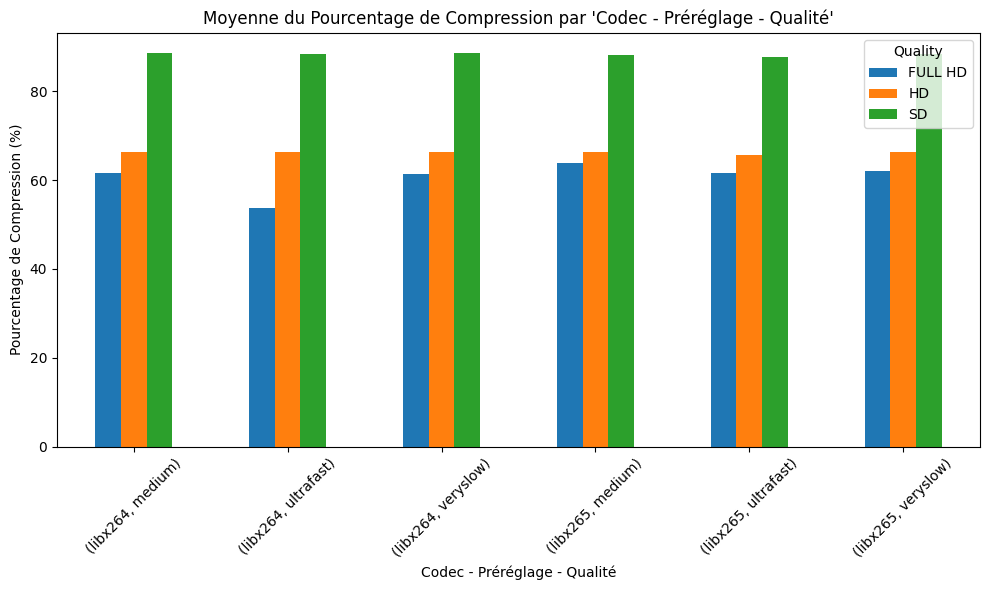

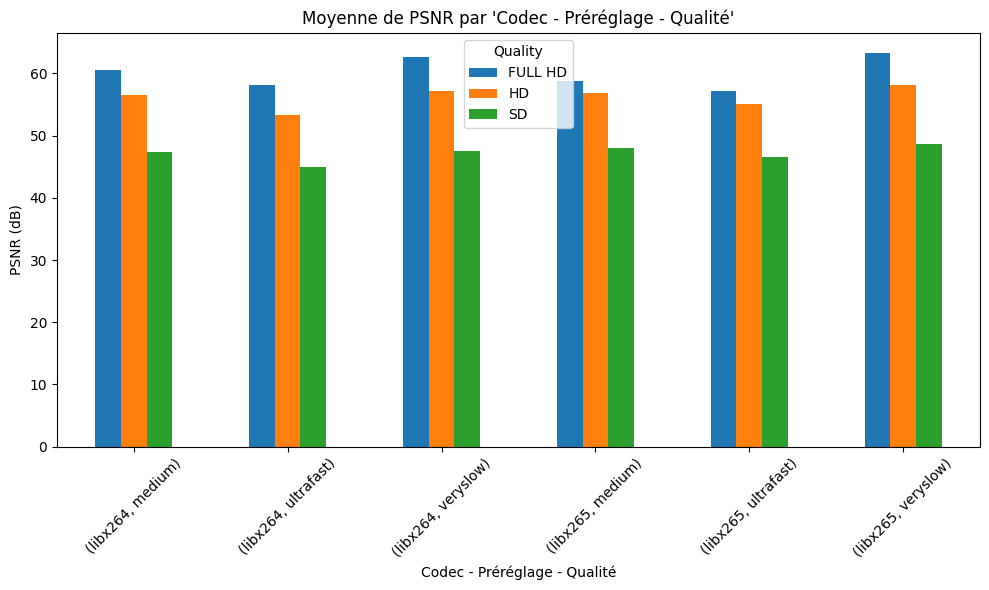

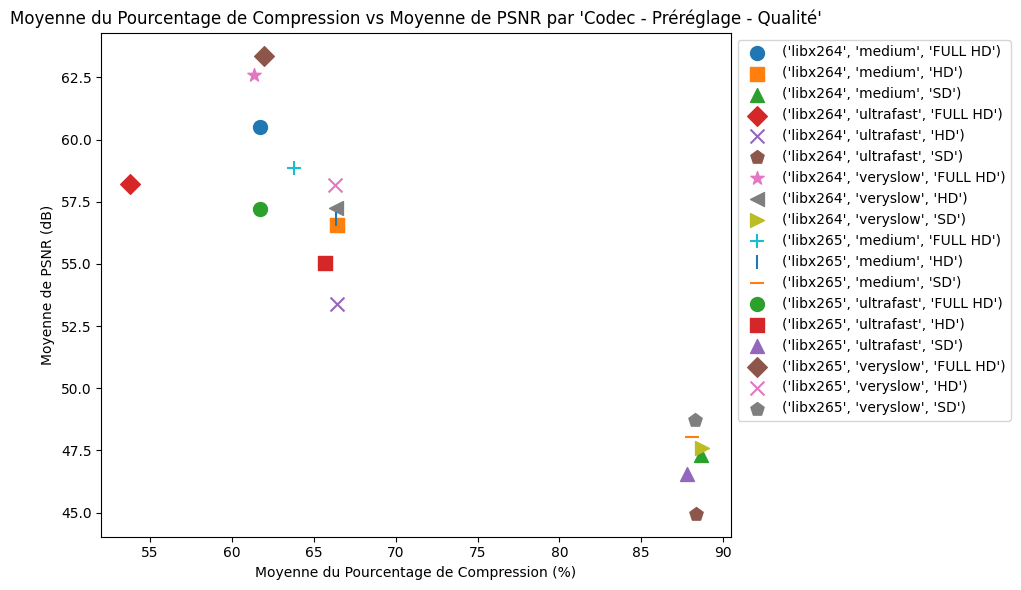

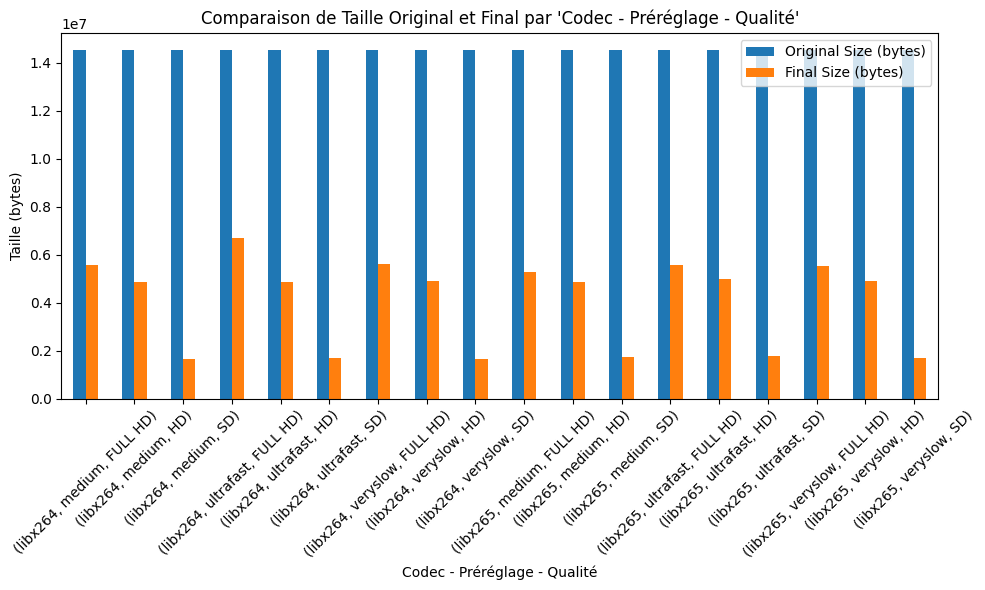

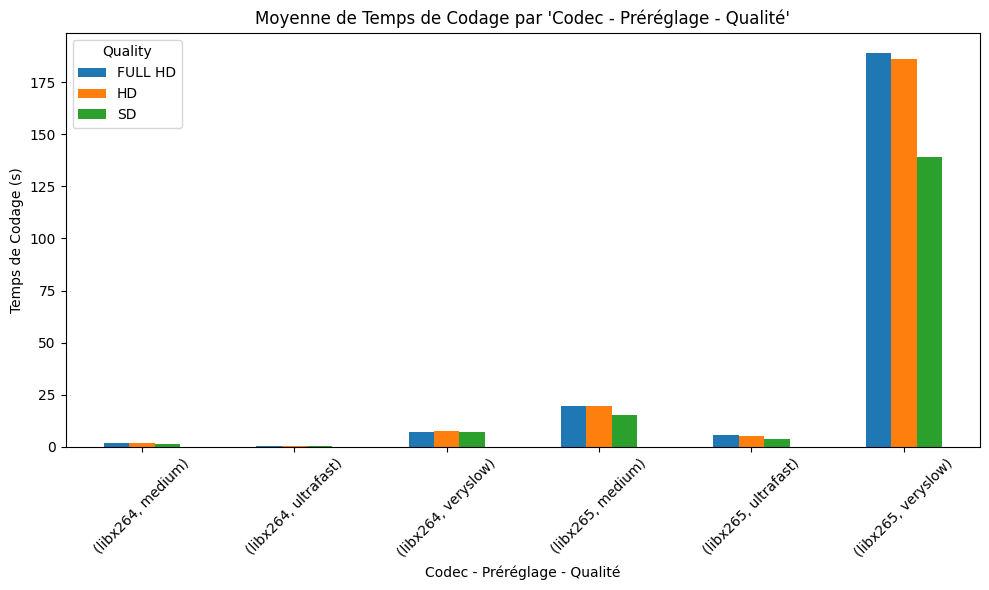

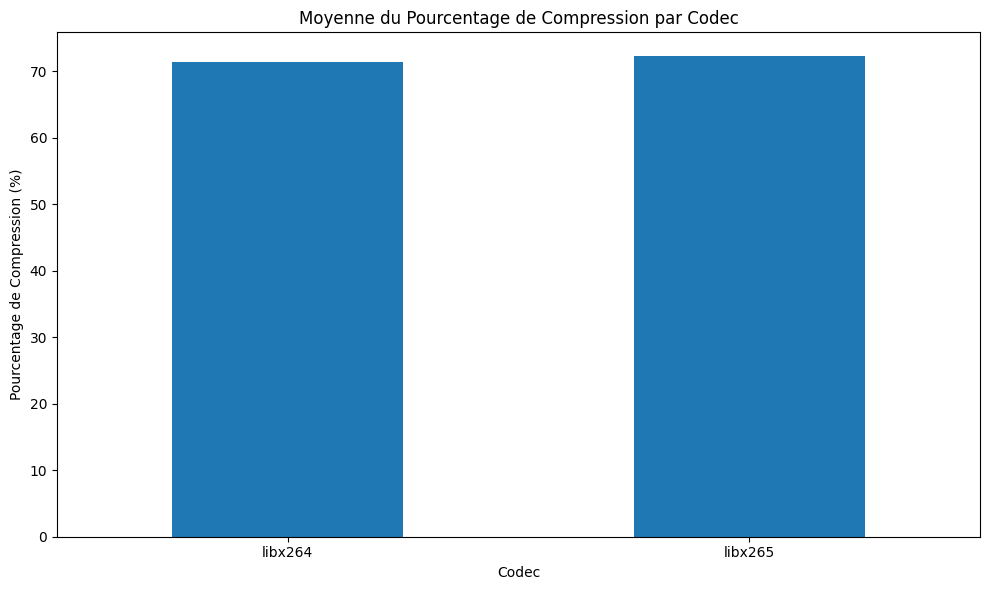

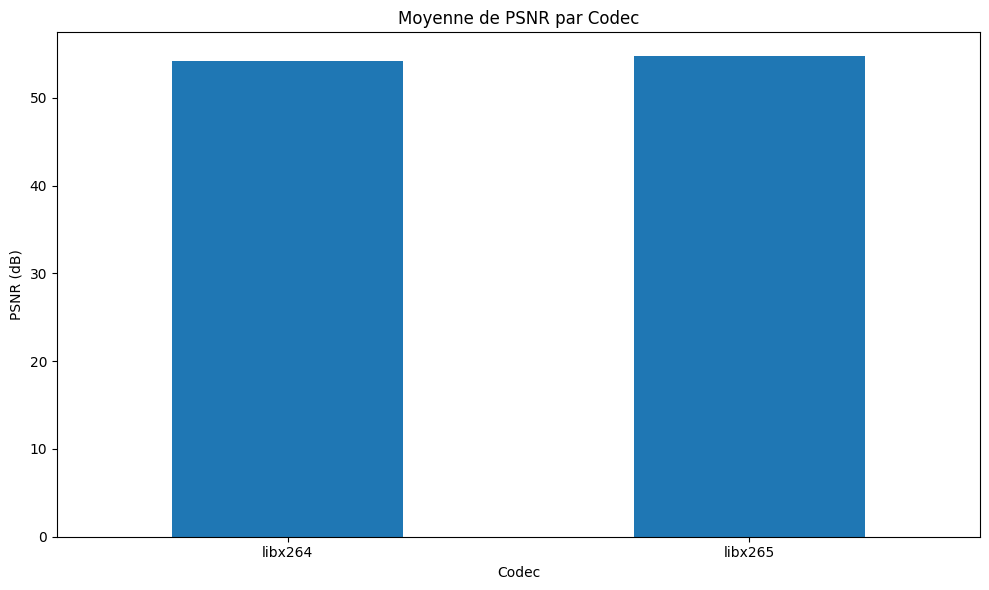

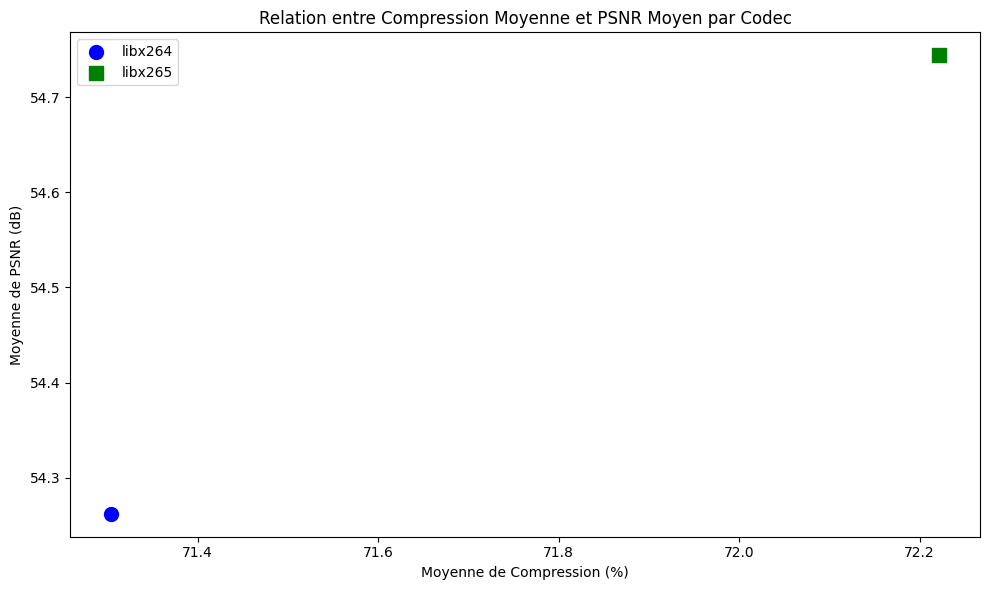

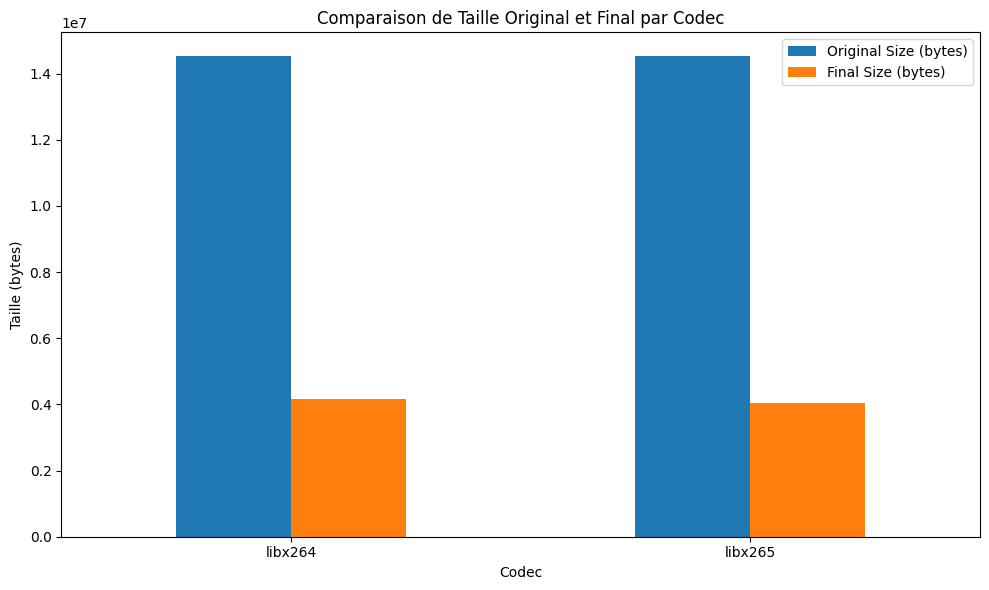

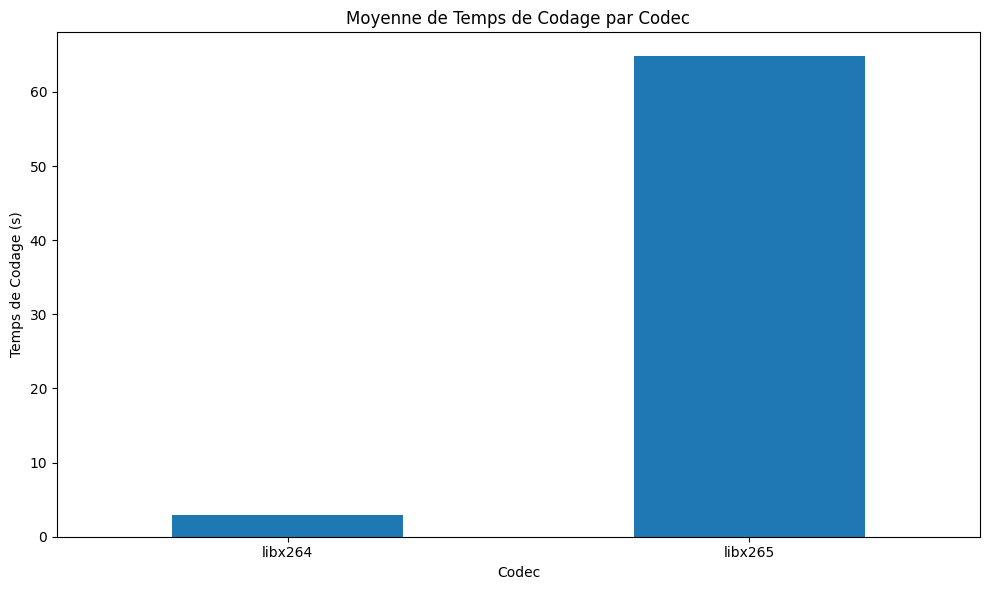

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Moyenne du pourcentage de compression par groupe selon "Codec - Préréglage - Qualité"
compression_avg = df.groupby(['Codec', 'Preset', 'Quality'])['Compression (%)'].mean()

# Histogramme
compression_avg.unstack().plot(kind='bar', figsize=(10, 6))
plt.title("Moyenne du Pourcentage de Compression par 'Codec - Préréglage - Qualité'")
plt.xlabel("Codec - Préréglage - Qualité")
plt.ylabel("Pourcentage de Compression (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Moyenne de la qualité visuelle (PSNR) par groupe selon "Codec - Préréglage - Qualité"
psnr_avg = df.groupby(['Codec', 'Preset', 'Quality'])['PSNR (dB)'].mean()

# Histogramme
psnr_avg.unstack().plot(kind='bar', figsize=(10, 6))
plt.title("Moyenne de PSNR par 'Codec - Préréglage - Qualité'")
plt.xlabel("Codec - Préréglage - Qualité")
plt.ylabel("PSNR (dB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Moyenne du Pourcentage de Compression VS Moyenne de PSNR par groupe
avg_compression_psnr = df.groupby(['Codec', 'Preset', 'Quality']).agg({
    'Compression (%)': 'mean',
    'PSNR (dB)': 'mean'
}).reset_index()

# Définir les formes des marqueurs
markers = ['o', 's', '^', 'D', 'x', 'p', '*', '<', '>', '+', '|', '_']
marker_map = {}

# Assigner une forme unique pour chaque combinaison
unique_combinations = avg_compression_psnr[['Codec', 'Preset', 'Quality']].drop_duplicates()
for idx, row in unique_combinations.iterrows():
    marker_map[tuple(row)] = markers[idx % len(markers)]

# Graphique
plt.figure(figsize=(10, 6))
for label, group in avg_compression_psnr.groupby(['Codec', 'Preset', 'Quality']):
    marker = marker_map[tuple(label)]  
    plt.scatter(group['Compression (%)'], group['PSNR (dB)'], label=f'{label}', marker=marker, s=100)

plt.title("Moyenne du Pourcentage de Compression vs Moyenne de PSNR par 'Codec - Préréglage - Qualité'")
plt.xlabel("Moyenne du Pourcentage de Compression (%)")
plt.ylabel("Moyenne de PSNR (dB)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 4) Comparaison du taille original et final par groupe de fichier
df.groupby(['Codec', 'Preset', 'Quality']).agg({'Original Size (bytes)': 'mean', 'Final Size (bytes)': 'mean'}).plot(kind='bar', figsize=(10, 6))
plt.title("Comparaison de Taille Original et Final par 'Codec - Préréglage - Qualité'")
plt.xlabel("Codec - Préréglage - Qualité")
plt.ylabel("Taille (bytes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5) Moyenne du temps de codage par groupe de fichier
encoding_time_avg = df.groupby(['Codec', 'Preset', 'Quality'])['Encoding Duration (s)'].mean()

# Histogramme
encoding_time_avg.unstack().plot(kind='bar', figsize=(10, 6))
plt.title("Moyenne de Temps de Codage par 'Codec - Préréglage - Qualité'")
plt.xlabel("Codec - Préréglage - Qualité")
plt.ylabel("Temps de Codage (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6) Moyenne du Pourcentage de Compression par codec
compression_avg_codec = df.groupby('Codec')['Compression (%)'].mean()

# Histogramme
compression_avg_codec.plot(kind='bar', figsize=(10, 6))
plt.title("Moyenne du Pourcentage de Compression par Codec")
plt.xlabel("Codec")
plt.ylabel("Pourcentage de Compression (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 7) Moyenne de PSNR par codec
psnr_avg_codec = df.groupby('Codec')['PSNR (dB)'].mean()

# Histogramme
psnr_avg_codec.plot(kind='bar', figsize=(10, 6))
plt.title("Moyenne de PSNR par Codec")
plt.xlabel("Codec")
plt.ylabel("PSNR (dB)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8) Relation entre Compression et PSNR par codec avec différentes formes pour chaque élément
compression_avg_codec = df.groupby('Codec')['Compression (%)'].mean()
psnr_avg_codec = df.groupby('Codec')['PSNR (dB)'].mean()

markers = ['o', 's', '^', 'D', 'v', '<', '>']  
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Graphique
plt.figure(figsize=(10, 6))
for i, codec in enumerate(compression_avg_codec.index):
    plt.scatter(compression_avg_codec.iloc[i], psnr_avg_codec.iloc[i], 
                label=codec, marker=markers[i % len(markers)], color=colors[i % len(colors)], s=100)

plt.title("Relation entre Compression Moyenne et PSNR Moyen par Codec")
plt.xlabel("Moyenne de Compression (%)")
plt.ylabel("Moyenne de PSNR (dB)")
plt.legend()
plt.tight_layout()
plt.show()

# 9) Comparaison du taille original et final par codec
df.groupby('Codec').agg({'Original Size (bytes)': 'mean', 'Final Size (bytes)': 'mean'}).plot(kind='bar', figsize=(10, 6))
plt.title("Comparaison de Taille Original et Final par Codec")
plt.xlabel("Codec")
plt.ylabel("Taille (bytes)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 10) Moyenne du temps de codage par codec
encoding_time_avg_codec = df.groupby('Codec')['Encoding Duration (s)'].mean()

# Histogramme
encoding_time_avg_codec.plot(kind='bar', figsize=(10, 6))
plt.title("Moyenne de Temps de Codage par Codec")
plt.xlabel("Codec")
plt.ylabel("Temps de Codage (s)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


BD-PSNR par codec (qualité SD):
libx264: -0.34 dB
libx265: -0.07 dB

BD-Rate par codec (qualité SD):
libx264: 2.76
libx265: 2.78

BD-PSNR par codec (qualité HD):
libx264: -0.62 dB
libx265: 0.02 dB

BD-Rate par codec (qualité HD):
libx264: 3.23
libx265: 3.23

BD-PSNR par codec (qualité Full HD):
libx264: 0.02 dB
libx265: 1.20 dB

BD-Rate par codec (qualité Full HD):
libx264: 3.36
libx265: 3.31


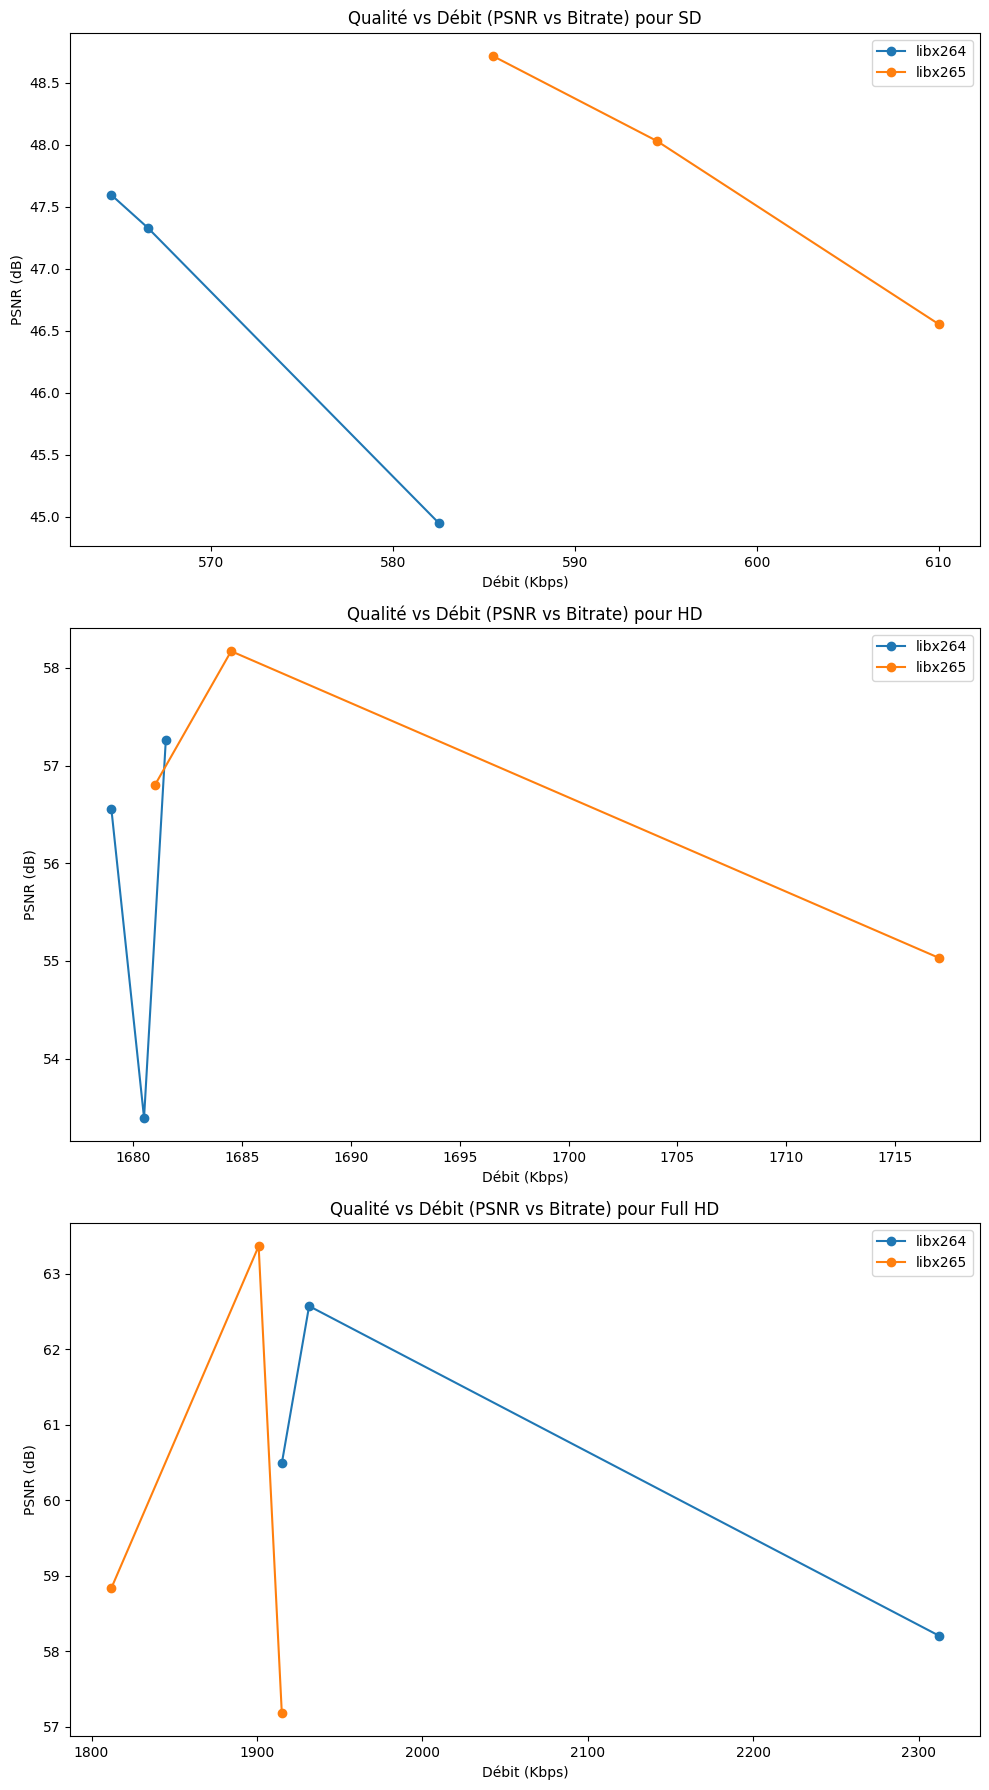

In [6]:
import numpy as np  
import pandas as pd
from scipy import interpolate
from scipy.integrate import trapezoid  # Importation de la fonction trapezoid
import matplotlib.pyplot as plt

# Assurons-nous que df est le DataFrame qui contient les résultats de codage
# Le DataFrame df doit inclure les colonnes "Codec", "Preset", "Compression (%)", "PSNR (dB)", "Bitrate (Kbps)" et "Quality"

# Convertir la compression (%) en Bitrate estimé pour chaque vidéo
def calculate_bitrate_from_compression(compression_percentage, original_bitrate):
    # Si la compression est de 50%, le bitrate sera réduit de moitié
    return original_bitrate * (1 - compression_percentage / 100)

# Préparer les résultats pour les calculs BD-PSNR et BD-Rate
def calculate_bd_metrics(df):
    bd_psnr_results = {}
    bd_rate_results = {}

    for codec in df['Codec'].unique():
        codec_data = df[df['Codec'] == codec]

        # Les bitrates et PSNR pour ce codec
        bitrates = codec_data['Compression (%)'].apply(lambda x: calculate_bitrate_from_compression(x, 5000))  # 5000 kbps comme référence
        psnr = codec_data['PSNR (dB)'].values

        # Trier les données par bitrate
        sorted_indices = np.argsort(bitrates)
        bitrates = bitrates.iloc[sorted_indices]
        psnr = psnr[sorted_indices]

        # Interpolation pour avoir des valeurs communes sur l'axe du débit
        interp_psnr = interpolate.interp1d(bitrates, psnr, kind='linear', fill_value='extrapolate')

        # Calcul du BD-PSNR
        def calculate_bd_psnr(bitrate, psnr1):
            log_bitrate = np.log10(bitrate)
            delta_psnr = psnr1 - np.mean(psnr1)  # Comparaison avec la moyenne
            bd_psnr = trapezoid(delta_psnr, log_bitrate) / (log_bitrate[-1] - log_bitrate[0])  # Remplacement de np.trapz par trapezoid
            return bd_psnr

        # Calcul du BD-Rate
        def calculate_bd_rate(bitrate, psnr1):
            log_bitrate = np.log10(bitrate)
            delta_bitrate = np.log10(np.abs(bitrate))  # BD-Rate : différence sur le débit
            bd_rate = trapezoid(delta_bitrate, psnr1) / (psnr1[-1] - psnr1[0])  # Remplacement de np.trapz par trapezoid
            return bd_rate

        bd_psnr = calculate_bd_psnr(bitrates.values, psnr)
        bd_rate = calculate_bd_rate(bitrates.values, psnr)

        bd_psnr_results[codec] = bd_psnr
        bd_rate_results[codec] = bd_rate

    return bd_psnr_results, bd_rate_results

# Filtrer les données pour chaque qualité
df_sd = df[df['Quality'] == 'SD']
df_hd = df[df['Quality'] == 'HD']
df_full_hd = df[df['Quality'] == 'FULL HD']

# Calculer les BD-PSNR et BD-Rate pour chaque codec et chaque qualité
bd_psnr_sd, bd_rate_sd = calculate_bd_metrics(df_sd)
bd_psnr_hd, bd_rate_hd = calculate_bd_metrics(df_hd)
bd_psnr_full_hd, bd_rate_full_hd = calculate_bd_metrics(df_full_hd)

# Affichage des résultats BD-PSNR et BD-Rate par codec et qualité
print("BD-PSNR par codec (qualité SD):")
for codec, bd_psnr in bd_psnr_sd.items():
    print(f"{codec}: {bd_psnr:.2f} dB")

print("\nBD-Rate par codec (qualité SD):")
for codec, bd_rate in bd_rate_sd.items():
    print(f"{codec}: {bd_rate:.2f}")

print("\nBD-PSNR par codec (qualité HD):")
for codec, bd_psnr in bd_psnr_hd.items():
    print(f"{codec}: {bd_psnr:.2f} dB")

print("\nBD-Rate par codec (qualité HD):")
for codec, bd_rate in bd_rate_hd.items():
    print(f"{codec}: {bd_rate:.2f}")

print("\nBD-PSNR par codec (qualité Full HD):")
for codec, bd_psnr in bd_psnr_full_hd.items():
    print(f"{codec}: {bd_psnr:.2f} dB")

print("\nBD-Rate par codec (qualité Full HD):")
for codec, bd_rate in bd_rate_full_hd.items():
    print(f"{codec}: {bd_rate:.2f}")

# Visualisation des courbes qualité-débit pour chaque qualité (SD, HD, Full HD)
colors = ['blue', 'green', 'red']

# Création des graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Tracer les courbes pour SD
for codec in df_sd['Codec'].unique():
    codec_data = df_sd[df_sd['Codec'] == codec]
    bitrates = codec_data['Compression (%)'].apply(lambda x: calculate_bitrate_from_compression(x, 5000))
    sorted_indices = np.argsort(bitrates)
    bitrates = bitrates.iloc[sorted_indices]
    psnr = codec_data['PSNR (dB)'].values[sorted_indices]
    axs[0].plot(bitrates, psnr, label=codec, marker='o')

axs[0].set_title("Qualité vs Débit (PSNR vs Bitrate) pour SD")
axs[0].set_xlabel("Débit (Kbps)")
axs[0].set_ylabel("PSNR (dB)")
axs[0].legend()

# Tracer les courbes pour HD
for codec in df_hd['Codec'].unique():
    codec_data = df_hd[df_hd['Codec'] == codec]
    bitrates = codec_data['Compression (%)'].apply(lambda x: calculate_bitrate_from_compression(x, 5000))
    sorted_indices = np.argsort(bitrates)
    bitrates = bitrates.iloc[sorted_indices]
    psnr = codec_data['PSNR (dB)'].values[sorted_indices]
    axs[1].plot(bitrates, psnr, label=codec, marker='o')

axs[1].set_title("Qualité vs Débit (PSNR vs Bitrate) pour HD")
axs[1].set_xlabel("Débit (Kbps)")
axs[1].set_ylabel("PSNR (dB)")
axs[1].legend()

# Tracer les courbes pour Full HD
for codec in df_full_hd['Codec'].unique():
    codec_data = df_full_hd[df_full_hd['Codec'] == codec]
    bitrates = codec_data['Compression (%)'].apply(lambda x: calculate_bitrate_from_compression(x, 5000))
    sorted_indices = np.argsort(bitrates)
    bitrates = bitrates.iloc[sorted_indices]
    psnr = codec_data['PSNR (dB)'].values[sorted_indices]
    axs[2].plot(bitrates, psnr, label=codec, marker='o')

axs[2].set_title("Qualité vs Débit (PSNR vs Bitrate) pour Full HD")
axs[2].set_xlabel("Débit (Kbps)")
axs[2].set_ylabel("PSNR (dB)")
axs[2].legend()

plt.tight_layout()
plt.show()
